In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import io
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import glob

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Using TensorFlow backend.


In [2]:

train_data_dir = 'train'
img_width = 64
img_height = 64
img_dim = img_width * img_height * 3 #RGB images
batch_size = 8



In [3]:
def get_images_from_directory(dir_path,extensions = ['jpg','jpeg','png']):
    '''
        Extracts filepaths of all the images with specified extensions from a folder
        
        Input:
            dir_path: string, full directory path
            extensions = list, list of valid extensions
        Output:
            list of valid filepaths
    '''
    
    types = ['{}/*.{}'.format(dir_path,e) for e in extensions]

    files_grabbed = []
    
    for files in types:
        files_grabbed.extend(glob.glob(files))
    
    return files_grabbed


In [4]:

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
# network parameters
input_shape = (img_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2



In [6]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(img_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 12288)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          6291968     encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [7]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= img_dim 
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 12288)             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 6294020   
_________________________________________________________________
decoder (Model)              (None, 12288)             6305280   
Total params: 12,599,300
Trainable params: 12,599,300
Non-trainable params: 0
_________________________________________________________________


In [8]:
head_files =  get_images_from_directory("train\\head\\")
X_train = []
y_train = []
for file in head_files:
    img = load_img(file, target_size=(img_height, img_width))
    x = img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    X_train.append(x)
    
imgs = np.concatenate(X_train, axis=0)
imgs.shape
X_train = np.reshape(imgs, [-1, img_dim])
X_train = X_train.astype('float32') / 255
X_train.shape

(50, 12288)

In [9]:
TEST_SIZE = 25
SAMPLE_SIZE = X_train.shape[0]
TRAIN_SIZE = SAMPLE_SIZE - TEST_SIZE
x_train = X_train[:TRAIN_SIZE]
x_test = X_train[TRAIN_SIZE:SAMPLE_SIZE]
x_train.shape, x_test.shape
epochs = 200

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 25 samples, validate on 25 samples
Epoch 1/200
25/25 [==============================] - 2s 84ms/step - loss: 8521.9248 - val_loss: 8111.9082
Epoch 2/200
25/25 [==============================] - 0s 9ms/step - loss: 8077.1270 - val_loss: 7624.4302
Epoch 3/200
25/25 [==============================] - 0s 10ms/step - loss: 7561.6050 - val_loss: 4594269696.0000
Epoch 4/200
25/25 [==============================] - 0s 10ms/step - loss: 3840225024.0000 - val_loss: 5495.8423
Epoch 5/200
25/25 [==============================] - 0s 9ms/step - loss: 5457.8955 - val_loss: 4499.9033
Epoch 6/200
25/25 [==============================] - 0s 9ms/step - loss: 4491.1255 - val_loss: 3415.8828
Epoch 7/200
25/25 [==============================] - 0s 10ms/step - loss: 3350.5369 - val_loss: 2742.3083
Epoch 8/200
25/25 [==============================] - 0s 10ms/step - loss: 2631.2180 - val_loss: 2456.0850
Epoch 9/200
25/25 [==============================] - 0s 11ms/step - loss: 2303.4885 - val_loss: 241

Epoch 78/200
25/25 [==============================] - 0s 10ms/step - loss: 1265.2340 - val_loss: 1339.5261
Epoch 79/200
25/25 [==============================] - 0s 9ms/step - loss: 1258.8035 - val_loss: 1329.5424
Epoch 80/200
25/25 [==============================] - 0s 9ms/step - loss: 1251.8624 - val_loss: 1327.2827
Epoch 81/200
25/25 [==============================] - 0s 9ms/step - loss: 1250.1743 - val_loss: 1321.9664
Epoch 82/200
25/25 [==============================] - 0s 10ms/step - loss: 1246.7502 - val_loss: 1317.2297
Epoch 83/200
25/25 [==============================] - 0s 9ms/step - loss: 1240.6444 - val_loss: 1310.1735
Epoch 84/200
25/25 [==============================] - 0s 10ms/step - loss: 1233.8258 - val_loss: 1304.4806
Epoch 85/200
25/25 [==============================] - 0s 9ms/step - loss: 1228.4774 - val_loss: 1301.3372
Epoch 86/200
25/25 [==============================] - 0s 9ms/step - loss: 1226.4897 - val_loss: 1295.6467
Epoch 87/200
25/25 [=======================

Epoch 155/200
25/25 [==============================] - 0s 9ms/step - loss: 1089.3112 - val_loss: 1159.7876
Epoch 156/200
25/25 [==============================] - 0s 9ms/step - loss: 1089.4766 - val_loss: 1157.9814
Epoch 157/200
25/25 [==============================] - 0s 9ms/step - loss: 1087.6050 - val_loss: 1158.1014
Epoch 158/200
25/25 [==============================] - 0s 9ms/step - loss: 1083.9192 - val_loss: 1153.5747
Epoch 159/200
25/25 [==============================] - 0s 9ms/step - loss: 1085.7661 - val_loss: 1155.1508
Epoch 160/200
25/25 [==============================] - 0s 9ms/step - loss: 1084.1306 - val_loss: 1155.0814
Epoch 161/200
25/25 [==============================] - 0s 9ms/step - loss: 1085.4136 - val_loss: 1153.5535
Epoch 162/200
25/25 [==============================] - 0s 9ms/step - loss: 1085.3514 - val_loss: 1153.0032
Epoch 163/200
25/25 [==============================] - 0s 9ms/step - loss: 1081.4420 - val_loss: 1154.9604
Epoch 164/200
25/25 [================

In [10]:
z_mean_head, _, _ = encoder.predict(x_test, batch_size = batch_size)

In [11]:
heart_files =  get_images_from_directory("train\\heart\\")
X_train = []
y_train = []
for file in heart_files:
    img = load_img(file, target_size=(img_height, img_width))
    x = img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    X_train.append(x)
    
imgs = np.concatenate(X_train, axis=0)
imgs.shape
X_train = np.reshape(imgs, [-1, img_dim])
X_train = X_train.astype('float32') / 255
X_train.shape

(190, 12288)

In [12]:
TEST_SIZE = 25
SAMPLE_SIZE = X_train.shape[0]
TRAIN_SIZE = SAMPLE_SIZE - TEST_SIZE
x2_train = X_train[:TRAIN_SIZE]
x2_test = X_train[TRAIN_SIZE:SAMPLE_SIZE]
x2_train.shape, x2_test.shape
epochs = 200

vae.fit(x2_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x2_test, None))

Train on 165 samples, validate on 25 samples
Epoch 1/200
165/165 [==============================] - 1s 4ms/step - loss: 6222.6542 - val_loss: 4559.1665
Epoch 2/200
165/165 [==============================] - 1s 4ms/step - loss: 4476.7334 - val_loss: 4815.5718
Epoch 3/200
165/165 [==============================] - 1s 4ms/step - loss: 4478.6213 - val_loss: 3643.6382
Epoch 4/200
165/165 [==============================] - 1s 4ms/step - loss: 3595.6197 - val_loss: 3745.6113
Epoch 5/200
165/165 [==============================] - 1s 4ms/step - loss: 3754.5392 - val_loss: 3381.0325
Epoch 6/200
165/165 [==============================] - 1s 4ms/step - loss: 3406.7573 - val_loss: 3242.1909
Epoch 7/200
165/165 [==============================] - 1s 4ms/step - loss: 3227.5968 - val_loss: 3197.5950
Epoch 8/200
165/165 [==============================] - 1s 4ms/step - loss: 3153.4840 - val_loss: 3187.9194
Epoch 9/200
165/165 [==============================] - 1s 4ms/step - loss: 3134.7645 - val_loss: 31

165/165 [==============================] - 1s 4ms/step - loss: 2811.7780 - val_loss: 2849.4753
Epoch 77/200
165/165 [==============================] - 1s 4ms/step - loss: 2810.5137 - val_loss: 2848.7610
Epoch 78/200
165/165 [==============================] - 1s 4ms/step - loss: 2808.9044 - val_loss: 2849.2180
Epoch 79/200
165/165 [==============================] - 1s 4ms/step - loss: 2808.4020 - val_loss: 2851.2153
Epoch 80/200
165/165 [==============================] - 1s 4ms/step - loss: 2808.2511 - val_loss: 2847.6868
Epoch 81/200
165/165 [==============================] - 1s 4ms/step - loss: 2807.4851 - val_loss: 2843.7798
Epoch 82/200
165/165 [==============================] - 1s 3ms/step - loss: 2807.7075 - val_loss: 2842.7512
Epoch 83/200
165/165 [==============================] - 1s 4ms/step - loss: 2806.3338 - val_loss: 2841.3965
Epoch 84/200
165/165 [==============================] - 1s 4ms/step - loss: 2806.2553 - val_loss: 2842.0547
Epoch 85/200
165/165 [===================

165/165 [==============================] - 1s 4ms/step - loss: 2783.1768 - val_loss: 2818.5710
Epoch 152/200
165/165 [==============================] - 1s 4ms/step - loss: 2783.1699 - val_loss: 2817.2122
Epoch 153/200
165/165 [==============================] - 1s 4ms/step - loss: 2782.9336 - val_loss: 2818.2776
Epoch 154/200
165/165 [==============================] - 1s 4ms/step - loss: 2783.4886 - val_loss: 2817.5627
Epoch 155/200
165/165 [==============================] - 1s 4ms/step - loss: 2783.0476 - val_loss: 2815.4832
Epoch 156/200
165/165 [==============================] - 1s 4ms/step - loss: 2782.5165 - val_loss: 2815.4539
Epoch 157/200
165/165 [==============================] - 1s 4ms/step - loss: 2781.7856 - val_loss: 2814.3809
Epoch 158/200
165/165 [==============================] - 1s 4ms/step - loss: 2782.0164 - val_loss: 2815.1677
Epoch 159/200
165/165 [==============================] - 1s 4ms/step - loss: 2781.5071 - val_loss: 2816.4241
Epoch 160/200
165/165 [==========

In [13]:

z_mean_heart, _, _ = encoder.predict(x2_test, batch_size = batch_size)
len(z_mean_head), len(z_mean_heart)


(25, 25)

In [14]:
z_mean = np.empty(shape=(50,2))
y_label = []
for i in range(25):
    for j in range(2):
        z_mean[i,j] = z_mean_head[i,j]
    y_label.append(0)
for i in range(25):
    for j in range(2):
        z_mean[25+i,j] = z_mean_heart[i,j]
    y_label.append(1)    
    

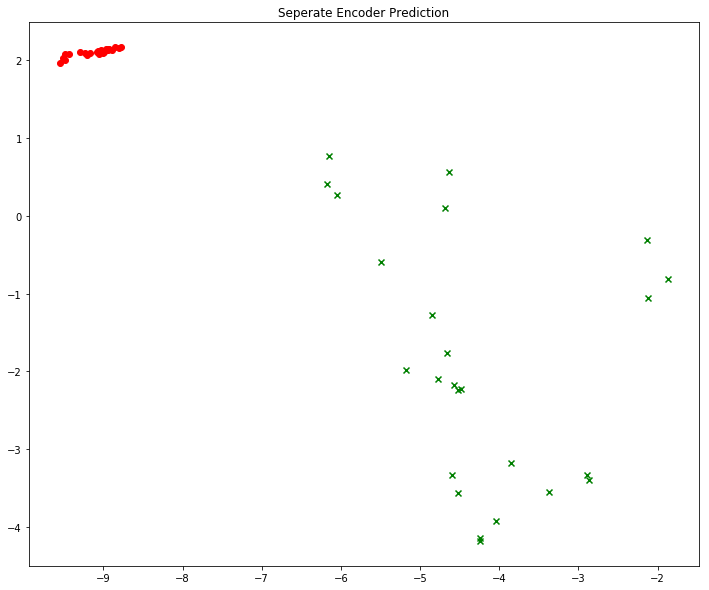

In [15]:
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:25,0], z_mean[:25,1], marker = 'o', c='r') #red- head
plt.scatter(z_mean[25:,0], z_mean[25:,1], marker = 'x', c='g') #green - heart
plt.title('Seperate Encoder Prediction')
plt.show()

Text(0.5, 1.0, 'KMeans Clustering - Seperate Encoder')

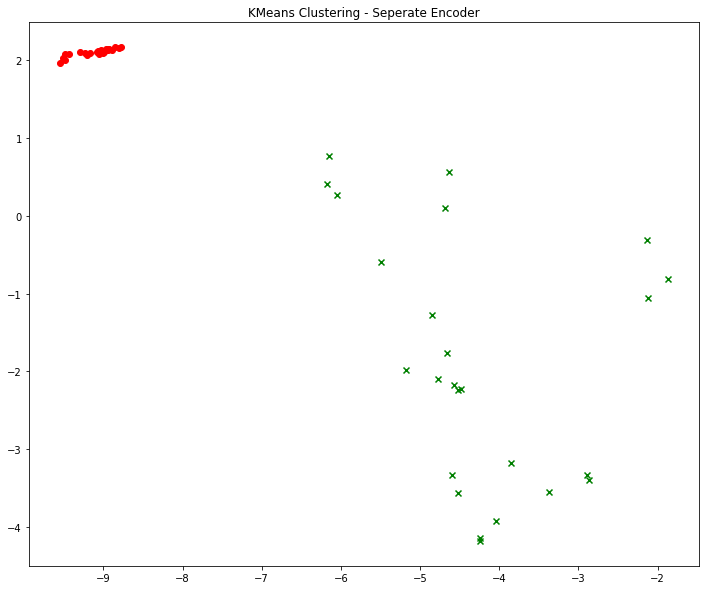

In [16]:
random_state = 170
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(z_mean)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:25,0], z_mean[:25,1], marker = 'o', c='r') #red- head
plt.scatter(z_mean[25:,0], z_mean[25:,1], marker = 'x', c='g') #green - heart
plt.title("KMeans Clustering - Seperate Encoder")

In [17]:
## one network - feed both image types

combined_train = np.concatenate((x_train, x2_train), axis=0)
print(x_train.shape, x2_train.shape, combined_train.shape)
combined_test = np.concatenate((x_test, x2_test), axis=0)
print(x_test.shape, x2_test.shape, combined_test.shape)

(25, 12288) (165, 12288) (190, 12288)
(25, 12288) (25, 12288) (50, 12288)


In [18]:
epochs = 200

vae.fit(combined_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(combined_test, None))

Train on 190 samples, validate on 50 samples
Epoch 1/200
190/190 [==============================] - 1s 4ms/step - loss: 2583.3415 - val_loss: 2105.0071
Epoch 2/200
190/190 [==============================] - 1s 4ms/step - loss: 2579.3493 - val_loss: 2081.0444
Epoch 3/200
190/190 [==============================] - 1s 4ms/step - loss: 2573.8169 - val_loss: 2066.6431
Epoch 4/200
190/190 [==============================] - 1s 4ms/step - loss: 2570.0577 - val_loss: 2048.1208
Epoch 5/200
190/190 [==============================] - 1s 4ms/step - loss: 2568.3199 - val_loss: 2035.1581
Epoch 6/200
190/190 [==============================] - 1s 4ms/step - loss: 2565.8902 - val_loss: 2025.9911
Epoch 7/200
190/190 [==============================] - 1s 4ms/step - loss: 2564.5353 - val_loss: 2023.9766
Epoch 8/200
190/190 [==============================] - 1s 4ms/step - loss: 2562.6342 - val_loss: 2015.7264
Epoch 9/200
190/190 [==============================] - 1s 4ms/step - loss: 2561.2023 - val_loss: 20

190/190 [==============================] - 1s 4ms/step - loss: 2517.7295 - val_loss: 1933.1294
Epoch 77/200
190/190 [==============================] - 1s 4ms/step - loss: 2518.0676 - val_loss: 1933.6104
Epoch 78/200
190/190 [==============================] - 1s 4ms/step - loss: 2517.5169 - val_loss: 1930.7115
Epoch 79/200
190/190 [==============================] - 1s 4ms/step - loss: 2516.2565 - val_loss: 1931.0681
Epoch 80/200
190/190 [==============================] - 1s 4ms/step - loss: 2516.7015 - val_loss: 1930.5793
Epoch 81/200
190/190 [==============================] - 1s 4ms/step - loss: 2516.2479 - val_loss: 1930.3676
Epoch 82/200
190/190 [==============================] - 1s 4ms/step - loss: 2515.9436 - val_loss: 1930.9897
Epoch 83/200
190/190 [==============================] - 1s 4ms/step - loss: 2515.6164 - val_loss: 1929.8666
Epoch 84/200
190/190 [==============================] - 1s 4ms/step - loss: 2515.8641 - val_loss: 1929.4385
Epoch 85/200
190/190 [===================

190/190 [==============================] - 1s 4ms/step - loss: 2492.5006 - val_loss: 1907.0956
Epoch 152/200
190/190 [==============================] - 1s 4ms/step - loss: 2492.1391 - val_loss: 1905.2267
Epoch 153/200
190/190 [==============================] - 1s 4ms/step - loss: 2492.7907 - val_loss: 1905.4391
Epoch 154/200
190/190 [==============================] - 1s 4ms/step - loss: 2492.4794 - val_loss: 1906.9458
Epoch 155/200
190/190 [==============================] - 1s 4ms/step - loss: 2492.1199 - val_loss: 1907.7935
Epoch 156/200
190/190 [==============================] - 1s 4ms/step - loss: 2493.9393 - val_loss: 1907.2864
Epoch 157/200
190/190 [==============================] - 1s 4ms/step - loss: 2493.1446 - val_loss: 1904.1592
Epoch 158/200
190/190 [==============================] - 1s 4ms/step - loss: 2490.7079 - val_loss: 1903.7177
Epoch 159/200
190/190 [==============================] - 1s 4ms/step - loss: 2490.4145 - val_loss: 1905.4565
Epoch 160/200
190/190 [==========

In [19]:
z_mean_head, _, _ = encoder.predict(x_test, batch_size = batch_size)
z_mean_heart, _, _ = encoder.predict(x2_test, batch_size = batch_size)

In [20]:
z_mean = np.empty(shape=(combined_test.shape[0],2))
y_label = []
for i in range(TEST_SIZE):
    for j in range(2):
        z_mean[i,j] = z_mean_head[i,j]
    y_label.append(0)
for i in range(TEST_SIZE):
    for j in range(2):
        z_mean[25+i,j] = z_mean_heart[i,j]
    y_label.append(1)    
    

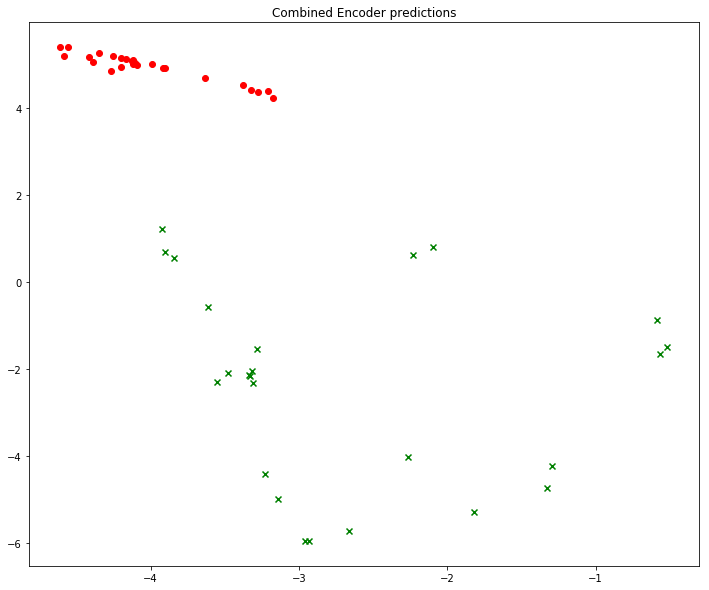

In [21]:
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:25,0], z_mean[:25,1], marker = 'o', c='r') #red- head
plt.scatter(z_mean[25:,0], z_mean[25:,1], marker = 'x', c='g') #green - heart
plt.title('Combined Encoder predictions')
plt.show()

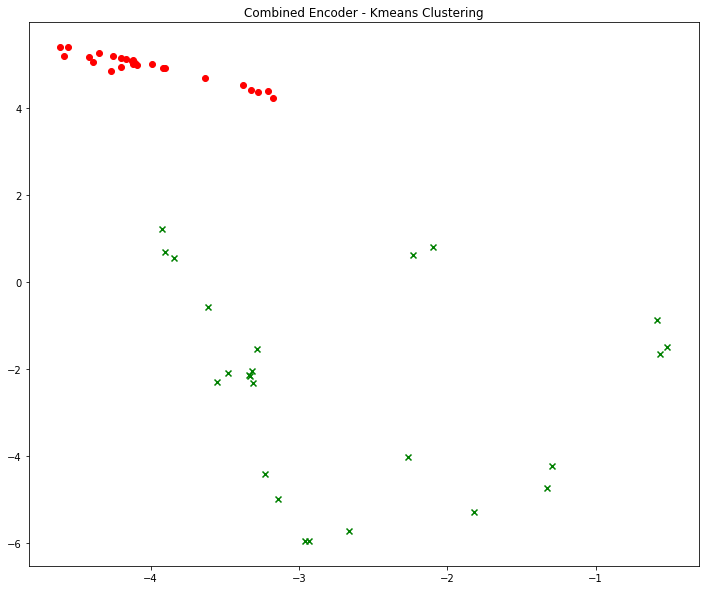

In [22]:
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:25,0], z_mean[:25,1], marker = 'o', c='r') #red- head
plt.scatter(z_mean[25:,0], z_mean[25:,1], marker = 'x', c='g') #green - heart
plt.title("Combined Encoder - Kmeans Clustering")
plt.show()

In [23]:
head_mr_pd = pd.read_csv('head_mr_tags.csv')
heart_ct_pd = pd.read_csv('heart_ct_tags.csv')
head_mr_pd.shape, heart_ct_pd.shape

((50, 25), (190, 25))

In [24]:
img_pd = head_mr_pd.iloc[-25:]
img_pd2 = heart_ct_pd.iloc[-25:]
frames = [img_pd, img_pd2]
result = pd.concat(frames)
result.columns


Index(['manufacturer', 'mnf_model_name', 'magn_field_strength', 'sw_ver',
       'study_uid', 'series_uid', 'acqu_contrast', 'bolus_agent',
       'phase_contrast', 'study_desc', 'series_desc', 'code_meaning',
       'part_examined', 'img_type', 'pulse_seq_name', 'acq_dev_proc_desc',
       'scanning_seq', 'protocol_name', 'hidden_pulse_seq', 'slice_thickness',
       'img_patnt_orientation', 'laterality', 'image_laterality',
       'frame_laterality', 'bolus_agent_phase'],
      dtype='object')

In [25]:
thickness = np.array(result['slice_thickness'])

In [26]:
a = np.array(result['magn_field_strength'])
where_are_NaNs = np.isnan(a)
a[where_are_NaNs] = 0



In [27]:
LE = LabelEncoder()
result['part_examined'] = LE.fit_transform(result['part_examined'])
result['sw_ver'] = LE.fit_transform(result['sw_ver'])
result['manufacturer'] = LE.fit_transform(result['manufacturer'])
result['mnf_model_name'] = LE.fit_transform(result['mnf_model_name'])
result['study_desc'] = LE.fit_transform(result['study_desc'])
result['series_desc'] = LE.fit_transform(result['series_desc'])
result['protocol_name'] = LE.fit_transform(result['protocol_name'])

In [28]:
result.head(4)

,manufacturer,mnf_model_name,magn_field_strength,sw_ver,study_uid,series_uid,acqu_contrast,bolus_agent,phase_contrast,study_desc,...,acq_dev_proc_desc,scanning_seq,protocol_name,hidden_pulse_seq,slice_thickness,img_patnt_orientation,laterality,image_laterality,frame_laterality,bolus_agent_phase
25,0,0,1.5,1,1.3.6.1.4.1.14519.5.2.1.3320.3273.330990048303...,1.3.6.1.4.1.14519.5.2.1.3320.3273.278473693116...,NaN,NaN,NaN,0,...,NaN,EP,1,NaN,5.0,"['0.99939602557605', '-0.0146183905707', '0.03...",NaN,NaN,NaN,NaN
26,0,0,1.5,1,1.3.6.1.4.1.14519.5.2.1.3320.3273.330990048303...,1.3.6.1.4.1.14519.5.2.1.3320.3273.278473693116...,NaN,NaN,NaN,0,...,NaN,EP,1,NaN,5.0,"['0.99939602557605', '-0.0146183905707', '0.03...",NaN,NaN,NaN,NaN
27,0,0,1.5,1,1.3.6.1.4.1.14519.5.2.1.3320.3273.330990048303...,1.3.6.1.4.1.14519.5.2.1.3320.3273.278473693116...,NaN,NaN,NaN,0,...,NaN,EP,1,NaN,5.0,"['0.99939602557605', '-0.0146183905707', '0.03...",NaN,NaN,NaN,NaN
28,0,0,1.5,1,1.3.6.1.4.1.14519.5.2.1.3320.3273.330990048303...,1.3.6.1.4.1.14519.5.2.1.3320.3273.278473693116...,NaN,NaN,NaN,0,...,NaN,EP,1,NaN,5.0,"['0.99939602557605', '-0.0146183905707', '0.03...",NaN,NaN,NaN,NaN


In [29]:
part_examined = np.array(result['part_examined'])

In [54]:
## create a 2*TEST_SIZE x 9 tags + 2 z_mean
dicom_vector = np.zeros(shape=(TEST_SIZE*2 , (9+2)))
for i in range(TEST_SIZE*2):
    dicom_vector[i] = [
                       z_mean[i,0], 
                       z_mean[i,1], 
                       np.array(result['manufacturer'])[i],
                       np.array(result['mnf_model_name'])[i],
                       a[i],
                       np.array(result['sw_ver'])[i],
                       np.array(result['study_desc'])[i],
                       np.array(result['series_desc'])[i],        
                       np.array(result['part_examined'])[i],                       
                       np.array(result['protocol_name'])[i], 
                       thickness[i]
                       ]

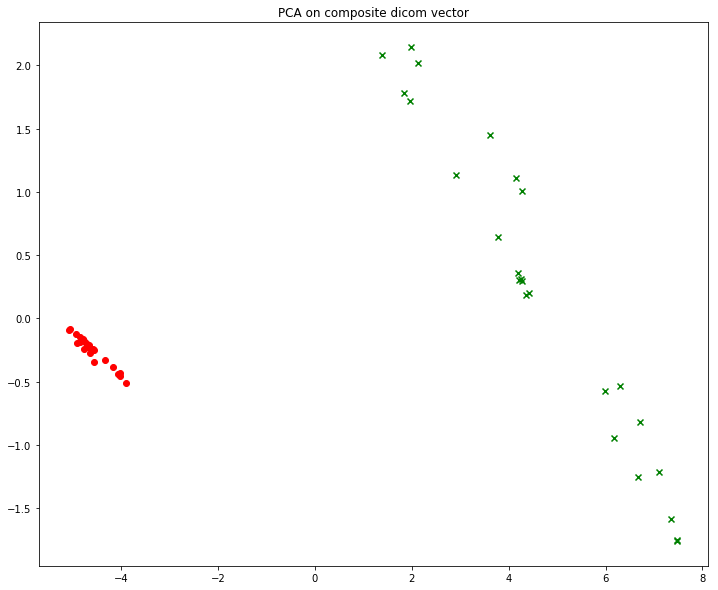

In [31]:
pca = PCA(n_components=2)
reduced_dicom_vector = pca.fit_transform(dicom_vector)
plt.figure(figsize=(12, 10))
plt.scatter(reduced_dicom_vector[:25,0], reduced_dicom_vector[:25,1], marker = 'o', c='r')
plt.scatter(reduced_dicom_vector[25:,0], reduced_dicom_vector[25:,1], marker = 'x', c='g')
plt.title("PCA on composite dicom vector")
plt.show()

In [55]:
## let's introduce errors in the dicom_vector to replicate erroroenous date
## let's add 3rd manufacturer and 3rd body part (even though we know the images belong to head or heart)


from random import randint
print(dicom_vector[:,2])
r = [randint(0, 49) for p in range(0, 20)] #40% 

for i in r:
    dicom_vector[i,2] = 1
    dicom_vector[i,5] = 1
print(dicom_vector[:,2])



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0.
 1. 0.]


In [56]:
print(dicom_vector[:,8])
for i in r:
    dicom_vector[i,8] = 2
print(dicom_vector[:,8])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[2. 0. 2. 0. 0. 2. 0. 2. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2. 0. 2. 0. 0. 2. 2.
 2. 1. 2. 1. 2. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 2. 2. 2. 1. 1. 1. 1. 2. 1.
 2. 1.]


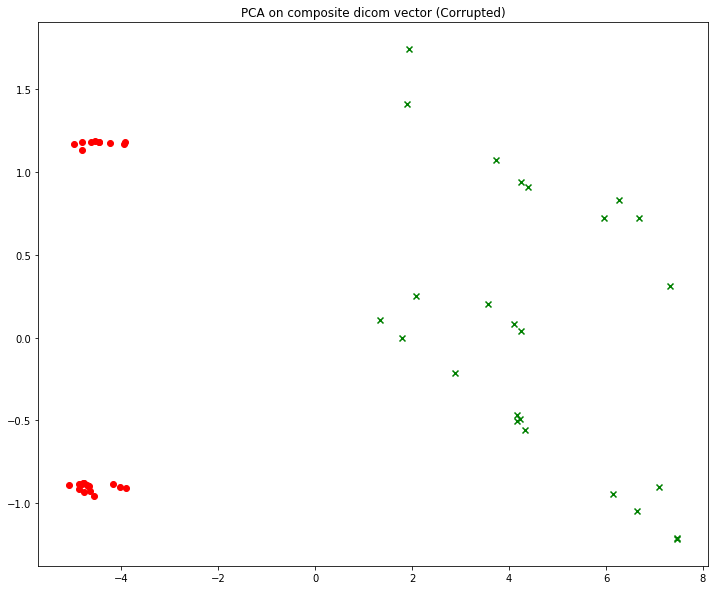

In [57]:
pca = PCA(n_components=2)
reduced_dicom_vector = pca.fit_transform(dicom_vector)
plt.figure(figsize=(12, 10))
plt.scatter(reduced_dicom_vector[:25,0], reduced_dicom_vector[:25,1], marker = 'o', c='r')
plt.scatter(reduced_dicom_vector[25:,0], reduced_dicom_vector[25:,1], marker = 'x', c='g')
plt.title("PCA on composite dicom vector (Corrupted)")
plt.show()